<div style="background: #eff6e0; border: thin solid black; padding: 5px">

# Task A - Predict OVR-Rating

## Rank The Players

- Use data from FIFA 19. Predict the Overall (OVR ) skill Statistic for players in the FIFA 20 Edition.
- Train on all players from FIFA 19
Graphically represent the Overall data for the players in Test Set

### Instructions :
1. Sofifa Id, URL, Name, Potential, Real face, URL variables cannot be used during the prediction or learning.
2. In case of a change in playing position, alter FIFA 20 position to match FIFA 19 Position
3. The final score will be assigned using MSE.

### Test Set: 
Players from the following Clubs
- FC Barcelona
- FC Bayern München
- Real Madrid
- Paris Saint-Germain
- Juventus
- Manchester City
- Liverpool FC

In [1]:
# settings
import os
import pathlib
working_dir = pathlib.Path().absolute()
os.chdir(working_dir)

In [2]:
# import
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate


<div style="background: #eff6e0; border: thin solid black; padding: 5px">

### Preparing and Cleaning Training Set
    
- Loading the dataset (players from 2019!) 
- Selecting subset of reasonable predictors 
- Cleaning dataset, i.e. dropping NaNs
- Assigning X_train & y_train
  

In [3]:
# load data
df = pd.read_csv('data/players_19.csv')

In [4]:
# instead, I am using the 6 aggregated FUT values - i.e. pace, shooting, etc..
df_mini_19 = df[['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'club', 'overall', 'player_positions']]

In [5]:
# drop all rows with NaNs
df_mini_19_cleaned = df_mini_19.dropna()

In [6]:
# prepare training data
X_train = df_mini_19_cleaned.drop(['overall', 'club', 'player_positions'], axis=1)
y_train = df_mini_19_cleaned['overall']

<div style="background: #eff6e0; border: thin solid black; padding: 5px">


### Preparing & Cleaning Test Set

- Loading the dataset (players from 2020!) 
- Selecting subset of predictors similar to test set
- Cleaning dataset, i.e. dropping NaNs
- Assigning X_test & y_test

In [7]:
# To begin with, rather than using all skill attributes, I'll be using the 6 aggregated FUT values - i.e. pace, shooting, etc..
df_mini_20 = pd.read_csv('data/players_20.csv')\
    [['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'club', 'overall', 'player_positions']]

In [8]:
# drop all rows with NaNs
df_mini_20_cleaned = df_mini_20.dropna()

In [9]:
# list 
list_of_clubs = ["FC Barcelona", "Juventus", "FC Bayern München", "Real Madrid", \
                 "Paris Saint-Germain","Manchester City", "Liverpool FC"]

df_mini_20_top_clubs = df_mini_20_cleaned[df_mini_20_cleaned['club'].isin(list_of_clubs)]

# display | sanity check
# display(df_mini_20_top_clubs)

In [10]:
# assign X_test and y_test
X_test = df_mini_20_top_clubs.drop(['overall', 'club', 'player_positions'], axis=1)
y_test = df_mini_20_top_clubs['overall']

<div style="background: #eff6e0; border: thin solid black; padding: 5px">

### Initial EDA

- Explore the test dataset
- Look at distributions of key attributes overall (using histograms)
- Explore relationhip between key attributes and OVR (using scatter plots)

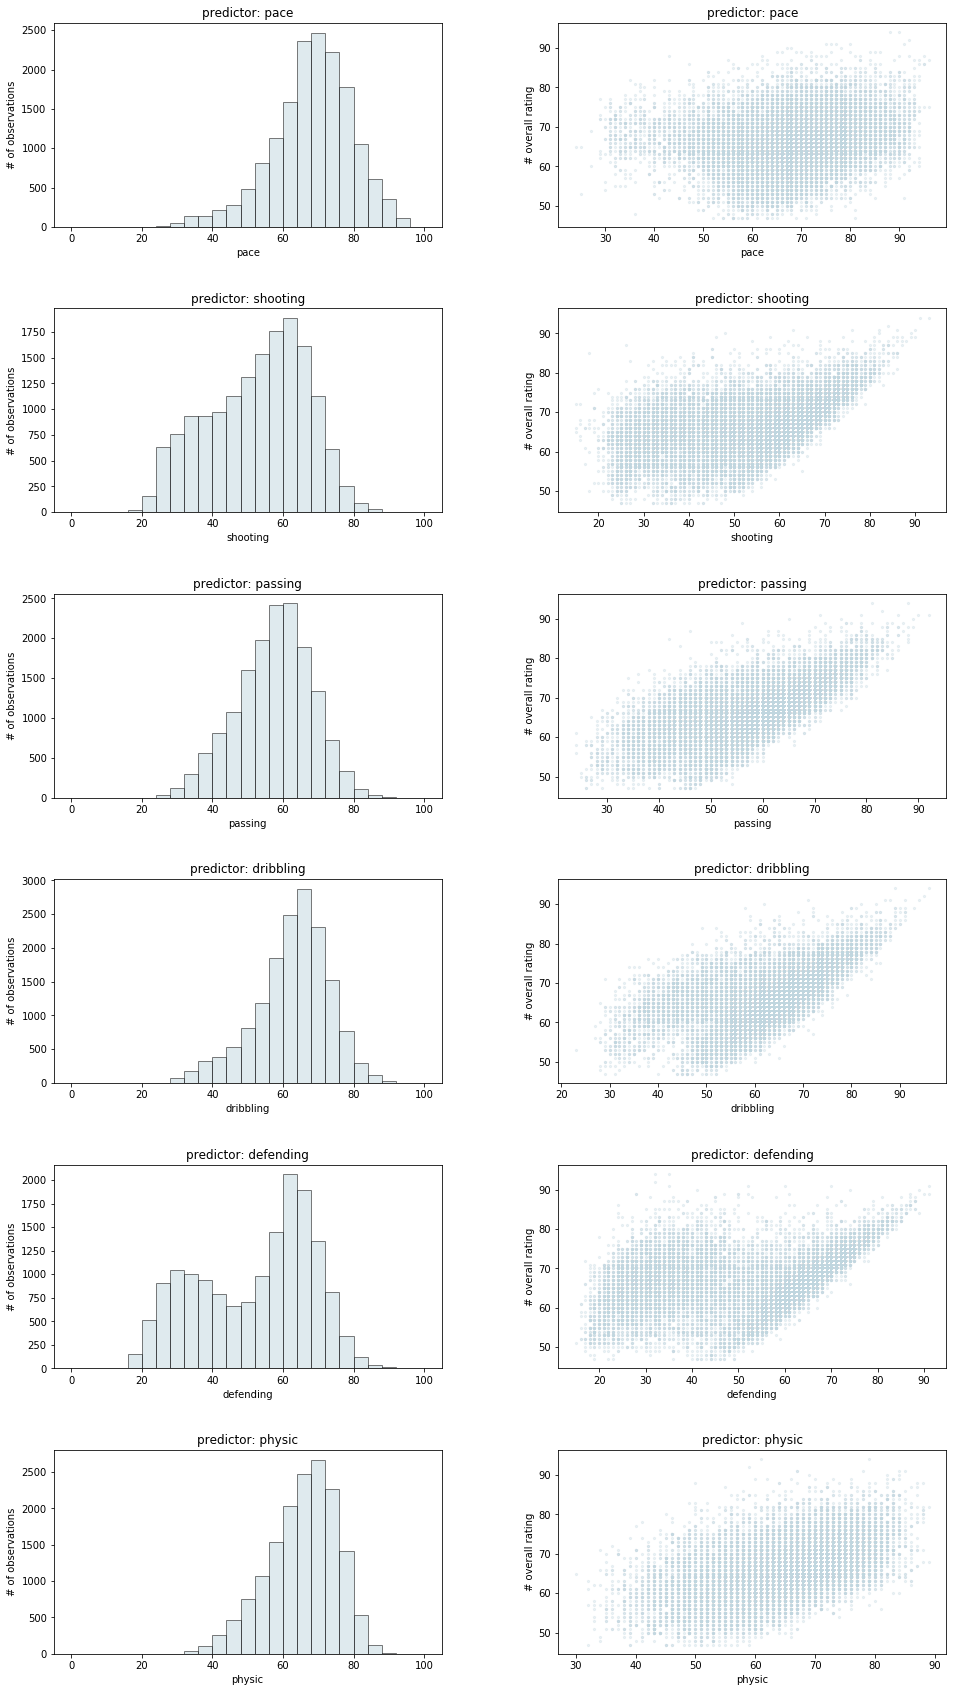

In [11]:
# show distributions of all 6 key skills
fig, ax = plt.subplots(6,2, figsize=(16,30))

# manage whitespace
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

# get list of all predictors
predictors = X_test.columns.values.tolist()

# bins
bins = np.linspace(0.0, 100.0, num=26)

# loop over all predictors, for each predictor
for row, predictor in zip( range(len(predictors)), predictors):
    
    # draw correctly predicted
    ax[row][0].hist( X_train[predictor], color='#c0d6df', bins=bins, alpha=0.5, ec='black')
     
    # labels etc.
    ax[row][0].set_xlabel(predictor)
    ax[row][0].set_ylabel("# of observations")
    ax[row][0].set_title(f"predictor: {predictor}")
    
    # draw correctly predicted
    ax[row][1].scatter(X_train[predictor], y_train, alpha=0.3, marker='.', s=20, color='#c0d6df', label='training data')

    # labels etc.
    ax[row][1].set_xlabel(predictor)
    ax[row][1].set_ylabel("# overall rating")
    ax[row][1].set_title(f"predictor: {predictor}")

<div style="background: #aec3b0; border: thin solid black; padding: 5px">

*Comments & Observations:*

On first sight, we observe a normal distribution for pace, passing, dribbling, and physical. For shooting, and defending, however, we observe a different behavior but why is the ability to shoot or to defend not normally distributed in the data set? The answer is that the data set contains all players from all positions. Since every position demands a different skillset, the data set includes both defenders, that cannot shoot well, attackers, that cannot defend well, as well as midfielders, that have a rather diverse skillset. To give an example, the ability to defend would be normally distributed across defenders but not across all players. What you'll see is another normal distribution of the defending skill within strikers and another normal distribution of the defending skill within midfielders somewhere shifted/translated in the lowe bins. The same holds true for the shooting skill, where the distribution is also obviously not 'normal'. This raises the question, whether a similar phenomen is also occuring for dribbling and passing with the exception that the different positions level it out a bit more so that it's not immediately recognizable. In order to explore the behaviour in greater detail and to strengthen the hypothesis, let's visually encode the player position using color.

In [12]:
# cluster player positions

# positions
defender = ['CB', 'LB', 'LWB', 'RB', 'RWB']
midfielder = ['LW', 'RW', 'LM', 'RM', 'CM', 'CDM', 'CAM']
striker = ['ST', 'CF']

# create subset dfs
defenders_train = df_mini_19_cleaned[df_mini_19_cleaned['player_positions'].str.contains('CB|LB|RB|LWB|RWB', regex=True)]
midfielders_train = df_mini_19_cleaned[df_mini_19_cleaned['player_positions'].str.contains('LW|LM|CDM|CM|CAM|RM|RW', regex=True)]
strikers_train = df_mini_19_cleaned[df_mini_19_cleaned['player_positions'].str.contains('ST|CF', regex=True)]

# display | sanity check
# display(strikers)

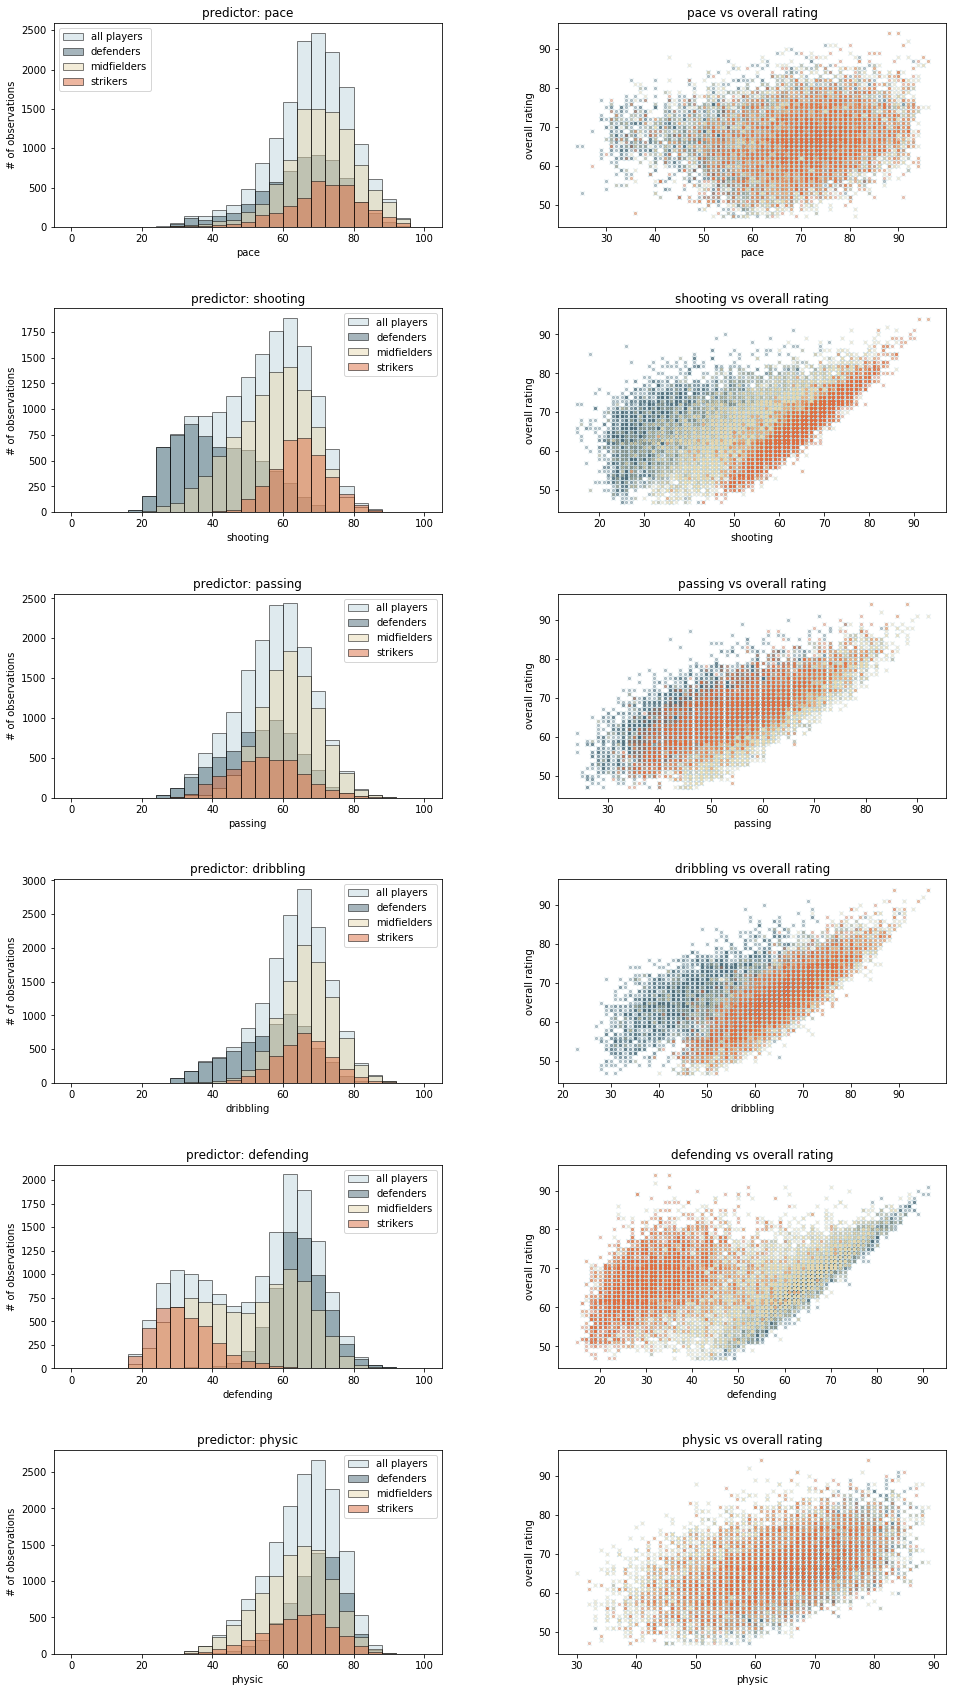

In [13]:

# bins
bins = np.linspace(0.0, 100.0, num=26)

# show distributions of all 6 key skills
fig, ax = plt.subplots(6,2, figsize=(16,30))

# manage whitespace
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

# get list of all predictors
predictors = df_mini_19.drop(['overall', 'club', 'player_positions'], axis=1).columns.values.tolist()

# loop over all predictors, for each predictor
for row, predictor in zip( range(len(predictors)), predictors):
    
    # draw correctly predicted
    ax[row][0].hist( X_train[predictor], color='#c0d6df', bins=bins, alpha=0.5, ec='black', label='all players')
    
    # defenders
    ax[row][0].hist( defenders_train[predictor], color='#4f6d7a', bins=bins, alpha=0.5, ec='black', label='defenders')
    
    # midfielders
    ax[row][0].hist( midfielders_train[predictor], color='#e8dab2', bins=bins, alpha=0.5, ec='black', label='midfielders')
    
    # strikers
    ax[row][0].hist( strikers_train[predictor], color='#dd6e42', bins=bins, alpha=0.5, ec='black', label='strikers')
     
    # labels etc.
    ax[row][0].set_xlabel(predictor)
    ax[row][0].set_ylabel("# of observations")
    ax[row][0].legend()
    ax[row][0].set_title(f"predictor: {predictor}")
    
    # draw correctly predicted
    ax[row][1].scatter(X_train[predictor], y_train, alpha=0.3, marker='x', s=20, color='#c0d6df', label='all data')
    
    # defenders
    ax[row][1].scatter(defenders_train[predictor], defenders_train['overall'], alpha=0.3, marker='.', s=20, color='#4f6d7a', label='defenders')
   
    # midfielders
    ax[row][1].scatter(midfielders_train[predictor], midfielders_train['overall'], alpha=0.3, marker='.', s=20, color='#e8dab2', label='midfielder')
  
    # striker
    ax[row][1].scatter(strikers_train[predictor], strikers_train['overall'], alpha=0.3, marker='.', s=20, color='#dd6e42', label='strikers')

    # labels etc.
    ax[row][1].set_xlabel(predictor)
    ax[row][1].set_ylabel(f"overall rating")
    ax[row][1].set_title(f"{predictor} vs overall rating")

<div style="background: #aec3b0; border: thin solid black; padding: 5px">

*Comments & Observations:*

After visually encoding the player positions, we learned a lot about the behavior of our predictors. It is in fact the case, that we have 3 sets of diverging normal distributions for each predictor based on the different player positions. What is of particular interest is that shooting and defening are two predictors that allow us to distinguish quite accurately between different player positions. Or to say it the other way around (since we are not trying to solve a logistic regression problem here), when knowing the player position, defending and shotting are very strong predictors. This is also true for passing and dribbling, while pace and physical do not help much in combination with the knowledge of the player position. Thus, it would be interesting to see to compare the performance of a model that uses only the four 4 predictors dribbling, passing, shooting, and defending compared to all 6 predictors. In addition to that, it is worth thinking about creating a module that is makes predictions based on the player position. There are a variety of ways to do so. We could either create dummy variables for player positions and use interaction terms. Or we could have three models that are trained based on different datasets that were filtered by player positions beforehand.

<div style="background: #eff6e0; border: thin solid black; padding: 5px">

## Basic Model

For the basic model, we just guess a degree and use polynomial features, to have a first model to work with. We'll then use Lasso and CV to get the best alpha and best degree. In a last step, we'll also include dummy variables and interaction terms for player positions.

In [14]:
# polynomial features
X_train_poly = PolynomialFeatures(degree=3).fit_transform(X_train)
X_test_poly = PolynomialFeatures(degree=3).fit_transform(X_test)

# model
lreg = LinearRegression()

# fit
# lreg.fit(X_train_poly, y_train)
lreg.fit(X_train_poly, y_train)  

# predict
y_pred_train = lreg.predict(X_train_poly)
y_pred_test = lreg.predict(X_test_poly)

In [15]:
# Compute the MSE
from sklearn.metrics import mean_squared_error
MSE_train = mean_squared_error(y_train, y_pred_train)
MSE_test = mean_squared_error(y_test, y_pred_test)

# report
MSE_train, MSE_test

(2.1207435104560175, 2.977022595042517)

<div style="background: #eff6e0; border: thin solid black; padding: 5px">

## Advanced Model I - Lasso & CV

In [16]:
# Finding best model, using Lasso & CV to find best degree!

In [17]:
# then, expand df with dummy variables for position! Then PF -> should provide interaction terms automatically -> done!

<div style="background: #eff6e0; border: thin solid black; padding: 5px">

## Advanced Model II - Interaction Terms

In [18]:
# NEED TO FIX PROBLEM WITH MULTIPLE POSITIONS

In [20]:
# prepare training set - Fifa 19 data
df_mini_19_cleaned_with_dummies = df_mini_19_cleaned.copy()

# init dummy variables
df_mini_19_cleaned_with_dummies['defender'] = 0
df_mini_19_cleaned_with_dummies['midfielder'] = 0
df_mini_19_cleaned_with_dummies['striker'] = 0

# set respective player positions to 1
df_mini_19_cleaned_with_dummies.loc[defenders_train.index,'defender'] = 1
df_mini_19_cleaned_with_dummies.loc[midfielders_train.index,'midfielder'] = 1
df_mini_19_cleaned_with_dummies.loc[strikers_train.index,'striker'] = 1

# sanity check
# df_mini_19_cleaned_with_dummies

In [21]:
# prepare test set - Fifa 20 data
df_mini_20_top_clubs_with_dummies = df_mini_20_top_clubs.copy()

# init dummy variables
df_mini_20_top_clubs_with_dummies['defender'] = 0
df_mini_20_top_clubs_with_dummies['midfielder'] = 0
df_mini_20_top_clubs_with_dummies['striker'] = 0

# get index of players with respect to their position
defenders_test = df_mini_20_top_clubs_with_dummies[df_mini_20_top_clubs_with_dummies['player_positions'].str.contains('CB|LB|RB|LWB|RWB', regex=True)]
midfielders_test = df_mini_20_top_clubs_with_dummies[df_mini_20_top_clubs_with_dummies['player_positions'].str.contains('LW|LM|CDM|CM|CAM|RM|RW', regex=True)]
strikers_test = df_mini_20_top_clubs_with_dummies[df_mini_20_top_clubs_with_dummies['player_positions'].str.contains('ST|CF', regex=True)]

# set respective player positions to 1
df_mini_20_top_clubs_with_dummies.loc[defenders_test.index,'defender'] = 1
df_mini_20_top_clubs_with_dummies.loc[midfielders_test.index,'midfielder'] = 1
df_mini_20_top_clubs_with_dummies.loc[strikers_test.index,'striker'] = 1

# sanity check
# df_mini_20_top_clubs_with_dummies

In [23]:
# assign X_train and y_train
X_train = df_mini_19_cleaned_with_dummies.drop(['overall', 'club', 'player_positions'], axis=1)
y_train = df_mini_19_cleaned_with_dummies['overall']

# assign X_test and y_test
X_test = df_mini_20_top_clubs_with_dummies.drop(['overall', 'club', 'player_positions'], axis=1)
y_test = df_mini_20_top_clubs_with_dummies['overall']


In [24]:
# polynomial features
X_train_poly = PolynomialFeatures(degree=3).fit_transform(X_train)
X_test_poly = PolynomialFeatures(degree=3).fit_transform(X_test)

# model
lreg = LinearRegression()

# fit
lreg.fit(X_train_poly, y_train)  

# predict
y_pred_train = lreg.predict(X_train_poly)
y_pred_test = lreg.predict(X_test_poly)

In [27]:
# MSE
MSE_train = mean_squared_error(y_pred_train, y_train)
MSE_test = mean_squared_error(y_pred_test, y_test)

# report
print(f'The MSE for the training data is {round(MSE_train, 4)}')
print(f'The MSE for the test data is {round(MSE_test, 4)}')

the MSE for the training data is 1.6073
the MSE for the test data is 1.9833


# NEXT STEPS: WRITE MODEL THAT USES ALL SKILLS AS PREDICTORS NOT JUST THE 6 FUT SKILLS

In [ ]:
# Exploring trimmed training data set

In [ ]:
# validation set

England = ['Manchester United', 'Manchester City', 'Chelsea', 'Liverpool', \
           'Arsenal', 'Tottenham Hotspur', 'Everton', 'Southampton', 'Burnley', \
          'West Ham United', 'Fulham', 'Wolverhampton Wanderers', 'Bournemouth', 'Crystal Palace', \
          'Leicester City', 'Huddersfield Town']

Italy = ['Juventus', 'Roma', 'Lazio', 'Sampdoria', 'Chievo Verona', 'Milan', 'Inter', 'Torino']

France = ['Paris Saint-Germain', 'Olympique Lyonnais', 'AS Monaco']

Spain = ['Real Madrid', 'FC Barcelona', 'Valencia CF', 'AtlÃ©tico Madrid', 'Athletic Club de Bilbao', \
         'Girona FC', 'Real Betis', 'SD Eibar', 'Sevilla FC', 'RCD Espanyol']

AllClubs = England + Italy + France + Spain

In [ ]:
df_val = df_mini_19_cleaned[df_mini_19_cleaned['club'].isin(AllClubs)]

X_val = df_val.drop(['overall', 'club'], axis=1)
y_val = df_val['overall']

# OLD CODE

In [ ]:
# first idea was to use all cols as predictors after dropping useless cols
# however, this will take a bit, so let's start with a smaller approach first

X_train = df.drop(['sofifa_id','player_url', 'short_name', 'long_name', 'dob', 'nationality', 'club', \
                   'overall', 'potential', 'player_positions', 'preferred_foot', 'work_rate', 'body_type', \
                   'real_face', 'release_clause_eur', 'player_tags', 'team_position', 'team_jersey_number', \
                   'loaned_from', 'joined', 'contract_valid_until', 'nation_position', 'nation_jersey_number'], axis=1)